In [1]:
import json
import os
import pickle
import sys

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import PATH_INTERIM_CORPUS  # noqa: E402
from src.config import PATH_BEST_MODELS, PICKLE_PROTOCOL  # noqa: E402

In [2]:
INTERIM_DATASETS_PATH = os.path.join(PATH_INTERIM_CORPUS, "xml/depression")

In [3]:
dmc_corpus_train = os.path.join(INTERIM_DATASETS_PATH, "depression-dmc-train.pkl")

with open(dmc_corpus_train, "rb") as fp:
    x_train, y_train, groups_train = pickle.load(fp)

In [4]:
dmc_corpus_test = os.path.join(INTERIM_DATASETS_PATH, "depression-dmc-test.pkl")

with open(dmc_corpus_test, "rb") as fp:
    x_test, y_test, _ = pickle.load(fp)

In [5]:
dtc = DecisionTreeClassifier(random_state=0)

In [6]:
# Set the parameters by cross-validation
parameters = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [3, 4],
    "min_samples_leaf": [1, 0.1, 10],
    "random_state": [42],
    "class_weight": [None, "balanced"],
}

In [7]:
gkf = GroupKFold(n_splits=21).split(x_train, y_train, groups_train)

for train_index, test_index in gkf:
    print(
        sum(y_train[idx] for idx in train_index),
        sum(y_train[idx] for idx in test_index),
    )

181 10
190 1
189 2
181 10
181 10
181 10
181 10
181 10
181 10
181 10
181 10
181 10
183 8
181 10
181 10
181 10
181 10
181 10
181 10
181 10
181 10


In [8]:
gkf = GroupKFold(n_splits=21).split(x_train, y_train, groups_train)

clf = GridSearchCV(dtc, parameters, cv=gkf, scoring="f1")

clf.fit(x_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f77a2724bd0>,
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
 

In [9]:
clf.best_score_, clf.best_params_

(0.5518763680376152,
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 1,
  'random_state': 42,
  'splitter': 'best'})

In [10]:
y_test_pred = clf.best_estimator_.predict(x_test)

In [11]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.40      0.56      1255
           1       0.18      0.82      0.29       197

    accuracy                           0.46      1452
   macro avg       0.56      0.61      0.43      1452
weighted avg       0.83      0.46      0.53      1452



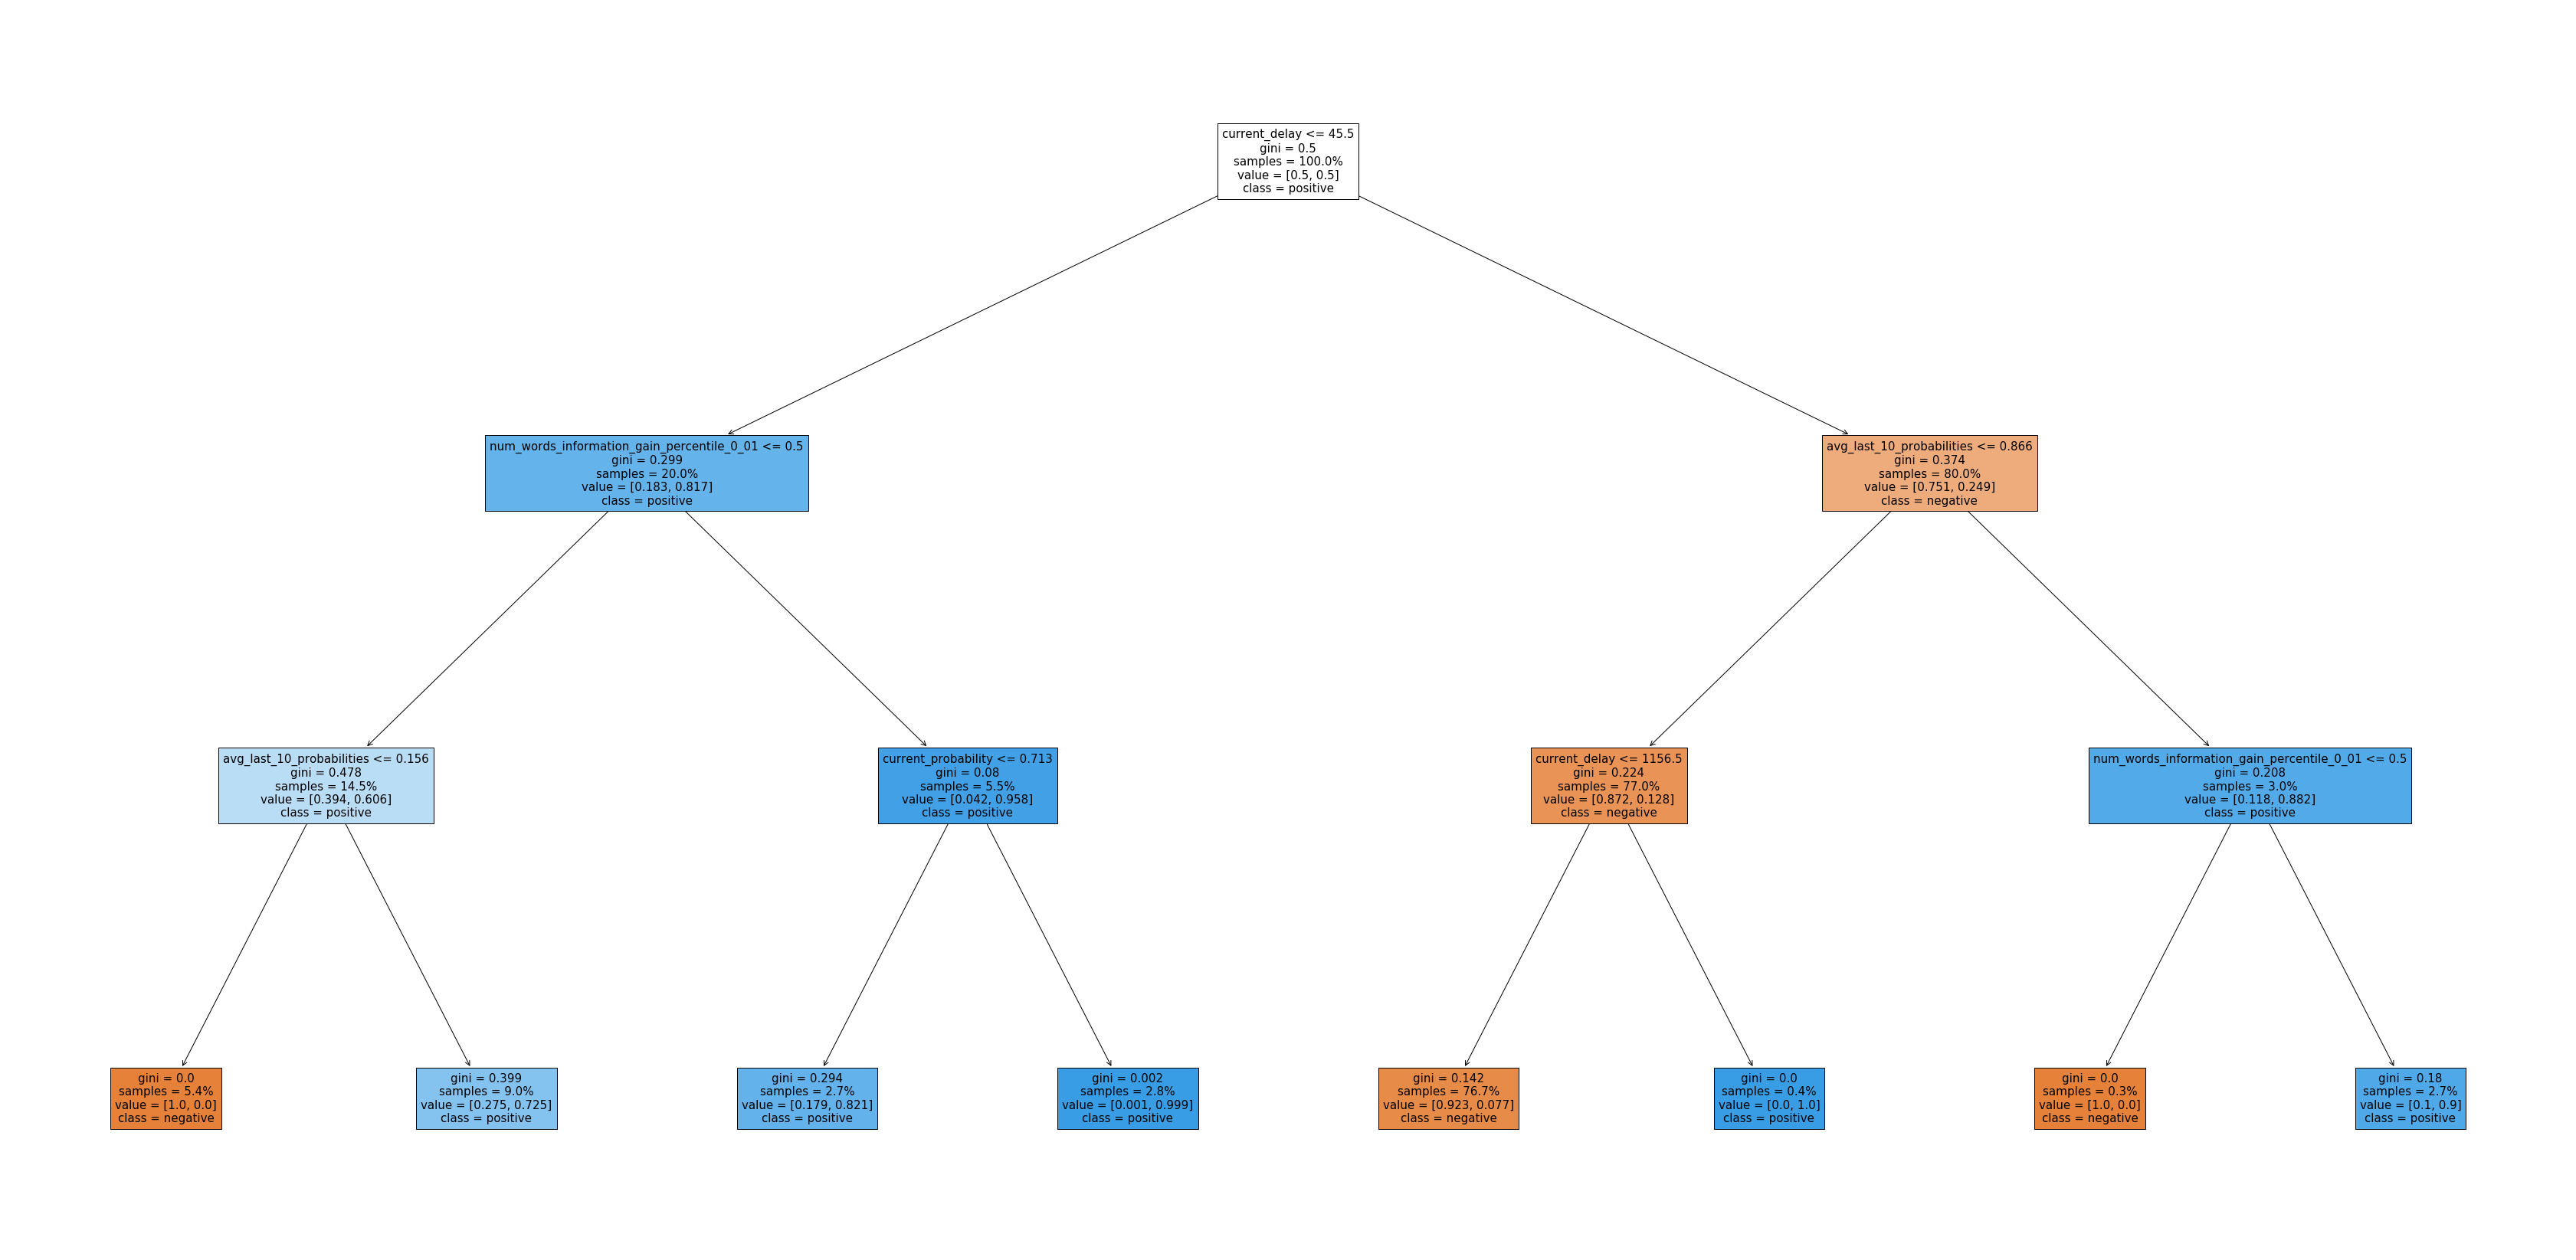

In [12]:
dmc_corpus_feature_names = os.path.join(
    INTERIM_DATASETS_PATH, "depression-dmc-feature-names.json"
)

with open(dmc_corpus_feature_names) as fp:
    feature_names = json.load(fp=fp)

class_names = ["negative", "positive"]

fig = plt.figure(figsize=(60, 30), facecolor="white")
plot_tree(
    clf.best_estimator_,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    proportion=True,
)
plt.show()

In [13]:
# Save model
model_path = os.path.join(
    PATH_BEST_MODELS,
    "positive_f1/reddit/depression/selected_models/dmc_decision_tree.pkl",
)

with open(model_path, "wb") as fp:
    pickle.dump(clf.best_estimator_, fp, protocol=PICKLE_PROTOCOL)